# I) Парсинг

Если у вас не установлены библиотеки, то запускаем следующий код:

In [ ]:
!pip install requests
!pip install bs4
!pip install lxml
!pip install selenium
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=99f8bc090298a3ca5d95cfae63914cb344ba809be2695dbfe81fd987fb0b50a6
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https

Подгружаем нужные библиотеки

In [1]:
#подгружаем нужные библиотеки
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

Собираем ссылки на объявления

In [ ]:
links = []
for i in range(100):
    #будем рабоать со страницей + номер страницы:
    link = 'https://moscow.drom.ru/auto/all/page' + str(i)
    
    #для начала отправляем запрос
    responce = requests.get(link).text

    #создаем объект (в качестве аргументов - значение аштимл и с помощью классов мы можем находить нужное значение на странице)
    soup = bs(responce, 'lxml')

    #достаем наш блок с данными, на странице объявления в нескольких блоках, поэтому будем использовать find_all
    block = soup.find_all('div', class_ = "css-1nvf6xk eojktn00")
    
    #служебный массив
    mass = []
    
    #перебираем в block и ищем наш разделитель - а, в нем получаем href и записываем в служебный массив
    for i in block:
        a = i.find_all('a')
        for j in a:
            mass.append(j.get('href'))
            
    #срезаем лишнее
    mass = mass[:20]
    
    #записываем наши ссылки в конечный массив
    for i in mass:
        links.append(i)

In [ ]:
#создаем нашу таблицу
df = pd.DataFrame(columns = ['Название', 
                             'Год', 
                             'Топливо', 
                             'Объем двигателя', 
                             'Мощность', 
                             'Коробка передач', 
                             'Привод', 
                             'Цвет', 
                             'Пробег',
                             'Руль',
                             'Оценка Drom',
                             'Цена'])

In [ ]:
#собираем данные с объявлений и вносим все в таблицу

#перебираем все ссылки в нашем массиве и создаем наш soup для каждой ссылки
for link in links:
    responce = requests.get(link).text
    soup = bs(responce, 'lxml')
    
    #проверяем не снято ли объявление с продажи, если снято - проходим мимо
    if 'Автомобиль снят с продажи' in str(soup.find('div', class_ = 'css-1bw6vfx edsrp6u2')):
        continue 
    #находим в soup блок с характеристиками и переделываем в строку
    block = str(soup.find('tbody'))

    #определяем название и год
    col = str(soup.find('span', class_ = 'css-1kb7l9z e162wx9x0'))[44:-20].split(', ')
    #случается такое, что по воле божей питон перестает на некоторых объявлениях видеть название. ограничиваем это
    if len(col) == 1:
        continue
    name = col[0]                     #название
    year = int(col[1])                   #год

    #работаем с данными по двигателю
    idx = block.find('Двигатель')
    if idx != -1: 
        engine = block[idx:]
        engine = engine[523:]
        engine = engine[:engine.find('<')]
    else:
        engine = ''
    if 'ГБО' in engine:
        engine = engine[:-5]
    if 'гибрид' in engine:
        engine = engine[:-8]
    mass_fuel = ['бензин', 'дизель', 'электро']
    fuel = ''
    for i in mass_fuel:
        if i in engine:
            fuel = i                                                #здесь определили топливо
            engine = engine.replace(i, '')[2:]
    if len(engine) != 0:
        volume = float(engine[:-2])                                 #здесь объем
    else:
        volume = ''


    #работаем по мощности
    power = block[block.find('Мощность'):]
    power = power[power.find('class="css-9g0qum e162wx9x0">'):][29:]
    power = power[:power.find('<!')]
    if len(power) >= 1:
        if power[0].isdigit() and power[-1].isdigit():
            power = int(power)
    else:
        power = ''

    #работаем по коробке передач
    idx = block.find('Коробка передач')
    transmission = ''
    if idx != -1: 
        transmission = block[idx:][52:]
        transmission = transmission[:transmission.find('<')]

    #определяем привод
    idx = block.find('Привод')
    drive = ''
    if idx != -1: 
        drive = block[idx:][43:]
        drive = drive[:drive.find('<')]

    #определяем цвет
    idx = block.find('Цвет')
    color = ''
    if idx != -1: 
        color = block[idx:][41:]
        color = color[:color.find('<')]

    #определяем руль
    idx = block.find('Руль')
    wheel = ''
    if idx != -1: 
        wheel = block[idx:][41:]
        wheel = wheel[:wheel.find('<')]

    #определяем пробег
    block = soup.find('span', class_ = 'css-1osyw3j ei6iaw00')
    mileage_mass = str(block)[35:-7].split('\xa0')

    mileage = ''
    for i in mileage_mass:
        mileage += i

    for i in mileage:
        if i.isdigit() == False:
            mileage = mileage[:mileage.find('i')]

    #определяем цену
    price_prep = str(soup.find('div', class_ = 'css-eazmxc e162wx9x0'))[34:-24].split('\xa0')
    price = ''
    for i in price_prep:
        price += i
    price = int(price)

    #определяем оценку авто по мнению дром
    score = str(soup.find('div', direction='column', class_ = 'css-obi42x eb0sjjd0'))[239:-6]

    #записываем собранные данные в список
    mass = [name, year, fuel, volume, power, transmission, drive, color, mileage, wheel, score, price]
    #добавляем список к таблице
    df.loc[len(df.index)] = mass

KeyboardInterrupt: ignored

In [ ]:
#сохраняем нашу таблицу
df.to_csv('auto3.csv')

# II) Обработка данных

In [ ]:
df_a = pd.read_csv('auto.csv', index_col=[0])
df_b = pd.read_csv('auto1.csv', index_col=[0])
df_c = pd.read_csv('auto2.csv', index_col=[0])
df_d = pd.read_csv('auto3.csv', index_col=[0])
# index_col=[0] чтобы не было лишнего столбца unnamed: 0

Создаем дополнительный датафрейм, который не будем изменять, чтобы сверяться, если что-то пойдет не так

In [ ]:
df_1 = pd.read_csv('auto.csv', index_col=[0])
df_2 = pd.read_csv('auto1.csv', index_col=[0])
df_3 = pd.read_csv('auto2.csv', index_col=[0])
df_4 = pd.read_csv('auto3.csv', index_col=[0])

In [ ]:
df = pd.concat([df_a, df_b, df_c, df_d], ignore_index=True) # соединяем четыре датафрейма
df1 = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [ ]:
#во-первых, у нас встречаются дубликаты из-за перекупов-дудосатакеров на дроме. Исправляем:
df.drop_duplicates(inplace = True, ignore_index = True ) #перезаписываем и сбрасываем индексы
df1.drop_duplicates(inplace = True, ignore_index = True )

In [ ]:
#во время парсинга пустые значения заполнялись пустой строкой, по факту это - NaN. Заменим на настоящие NaN
df.replace('', np.NaN, inplace = True) #сразу перезаписываем таблицу
df1.replace('', np.NaN, inplace = True)

### Что за данные у нас вообще получились?

In [ ]:
df1.head()

In [ ]:
df1.describe()

Ого! на дроме даже продают раритетные тачки!

In [61]:
df.loc[df['Год'] == 1950]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
885,BMW 340,1950,бензин,2.00,55.00,механика,задний,черный,50000.00,левый,8.60,5600000


Посмотрим, сколько NaNов в наших столбцах

In [ ]:
df1.isnull().sum()

Посмотрим на тепловую карту корреляции пропущенных значений

По сути, она показывает насколько сильно присутствие или отсутствие значений одного признака влияет на присутствие значений другого.

In [ ]:
msno.heatmap(df1);

Видно, что есть явная корреляция между приводом и топливом, коробкой передач и мощностью, приводом и топливом

Глянем более наглядно на заполненность данных по столбцам

In [ ]:
msno.matrix(df1);

Видно, что больше всего пропусков встречаются в Оценке Drom, Пробеге и Цвете

## Начнем с пробега

Есть подозрение, что пропуски в пробеге говорят о том, что там просто новые машинки, которые еще не успели поездить

Проверим это по году выпуска? Будем считать, что право на нулевой пробег имеют только машины от 2022 года выпуска и младше

In [ ]:
df1[(df1['Пробег'].isna()) & (df1['Год']<2022)]

Пробежимся по средним значениям для каждого года выпуска, присвоим нулевым пробегам эти значения соответственно

In [ ]:
df.at [172, 'Пробег'] = df.loc[df['Год'] == 2019, 'Пробег'].mean()

In [ ]:
df.at [342, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [384, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [398, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [470, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [494, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [876, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [879, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [898, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [1044, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [1328, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()

In [ ]:
df.at [175, 'Пробег'] = df.loc[df['Год'] == 2007, 'Пробег'].mean()
df.at [848, 'Пробег'] = df.loc[df['Год'] == 2007, 'Пробег'].mean()

In [ ]:
df.at [176, 'Пробег'] = df.loc[df['Год'] == 2015, 'Пробег'].mean()

In [ ]:
df.at [844, 'Пробег'] = df.loc[df['Год'] == 2002, 'Пробег'].mean()

In [ ]:
df.at [178, 'Пробег'] = df.loc[df['Год'] == 2008, 'Пробег'].mean()

In [ ]:
df[(df['Пробег'].isna()) & (df['Год']<2022)]

Остались только подозрительные строки дудоссеров, их удалим вообще

In [ ]:
df.drop(axis=0, index=343, inplace=True)
df.drop(axis=0, index=400, inplace=True)
df.drop(axis=0, index=401, inplace=True)
df.drop(axis=0, index=846, inplace=True)

Ну вот, теперь все старые машины остались без нулевого пробега, сделаем новым пробег=0 вместо NaN

In [ ]:
df['Пробег'].fillna(value=0, inplace=True)

## Следующим большим вопросом стала Оценка Drom. 

Там столько пропусков, что появляется желание ее удалить вообще... Однако, возможно, она нам еще пригодится...Заменим ее на среднее(8.602), тк по 10-балльной шкале, как выяснилось, минимум -- 7.5, а максимум -- 8.9, поэтому медиана(8.7) не так репрезентативна

In [ ]:
df['Оценка Drom'].fillna(value=8.602, inplace=True)

## Отлично! Теперь разберемся с мощностью

In [ ]:
df[(df['Мощность'].isna())]

Здесь опять на лицо куча дудос-строк, избавимся от них


In [ ]:
df.drop(axis=0, index=344, inplace=True)
df.drop(axis=0, index=358, inplace=True)
df.drop(axis=0, index=359, inplace=True)
df.drop(axis=0, index=414, inplace=True)
df.drop(axis=0, index=433, inplace=True)
df.drop(axis=0, index=497, inplace=True)
df.drop(axis=0, index=496, inplace=True)
df.drop(axis=0, index=502, inplace=True)
df.drop(axis=0, index=505, inplace=True)
df.drop(axis=0, index=508, inplace=True)
df.drop(axis=0, index=510, inplace=True)
df.drop(axis=0, index=512, inplace=True)
df.drop(axis=0, index=522, inplace=True)
df.drop(axis=0, index=879, inplace=True)
df.drop(axis=0, index=876, inplace=True)
df.drop(axis=0, index=495, inplace=True)
df.drop(axis=0, index=344, inplace=True)
df.drop(axis=0, index=358, inplace=True)

In [ ]:
df[(df['Мощность'].isna())]

Кажется логичным NaNовую мощность у Hyundai Solaris заменить на 123

In [ ]:
df[(df['Мощность']!=0) & (df['Название']=='Hyundai Solaris')]

In [ ]:
df.at [130, 'Мощность'] = 123.0
df.at [368, 'Мощность'] = 123.0

Проделываем то же для остальных марок

In [ ]:
df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()

Заменим NaNовую мощность у Kia Sorento на медианную, тк она более выбросоустойчива, чем средняя, хотя они и очень близки

In [ ]:
df.at [141, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()
df.at [1302, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()
df.at [1363, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()

In [ ]:
df.at [345, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()
df.at [362, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()
df.at [636, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()

In [ ]:
df.at [147, 'Мощность'] = df.loc[df['Название'] == 'Toyota Camry', 'Мощность'].median()

In [ ]:
df.at [339, 'Мощность'] = df.loc[df['Название'] == 'Kia Sportage', 'Мощность'].median()
df.at [349, 'Мощность'] = df.loc[df['Название'] == 'Kia Sportage', 'Мощность'].median()

In [ ]:
df.at [346, 'Мощность'] = df.loc[df['Название'] == 'Kia Rio', 'Мощность'].median()
df.at [350, 'Мощность'] = df.loc[df['Название'] == 'Kia Rio', 'Мощность'].median()

In [ ]:
df.at [360, 'Мощность'] = df.loc[df['Название'] == 'Mitsubishi Pajero', 'Мощность'].median()
df.at [1366, 'Мощность'] = df.loc[df['Название'] == 'Mitsubishi Pajero', 'Мощность'].median()

In [ ]:
df.at [347, 'Мощность'] = df.loc[df['Название'] == 'Haval F7', 'Мощность'].median()

In [ ]:
df.at [348, 'Мощность'] = df.loc[df['Название'] == 'SsangYong Kyron', 'Мощность'].median()

In [ ]:
df.at [351, 'Мощность'] = df.loc[df['Название'] == 'Nissan Juke', 'Мощность'].median()

А вот Volvo XC70 оказалась одной единственной машинкой этой марки, так что пришлось поискать в интернете, какая у нее могла бы быть мощность в теории

In [ ]:
df.at [352, 'Мощность'] = 215

In [ ]:
df.at [353, 'Мощность'] = df.loc[df['Название'] == 'Citroen Berlingo', 'Мощность'].median()

Peugeot Partner тоже найдем в интернетах

In [ ]:
df.at [355, 'Мощность'] = 75

In [ ]:
df.at [356, 'Мощность'] = df.loc[df['Название'] == 'Kia Ceed', 'Мощность'].median()

In [ ]:
df.at [367, 'Мощность'] = df.loc[df['Название'] == 'Skoda Octavia', 'Мощность'].median()
df.at [789, 'Мощность'] = df.loc[df['Название'] == 'Skoda Octavia', 'Мощность'].median()

In [ ]:
df.at [369, 'Мощность'] = df.loc[df['Название'] == 'Skoda Rapid', 'Мощность'].median()

In [ ]:
df.at [409, 'Мощность'] = df.loc[df['Название'] == 'Changan UNI-K', 'Мощность'].median()

Changan CS95 тоже найдем в интернетах

In [ ]:
df.at [411, 'Мощность'] = 233

Toyota Highlander	2022	бензин	тоже

In [ ]:
df.at [432, 'Мощность'] = 244

Лада 2102 тоже :)

In [ ]:
df.at [565, 'Мощность'] = 64

In [ ]:
df.at [1145, 'Мощность'] = df.loc[df['Название'] == 'Ford Focus', 'Мощность'].median()
df.at [1304, 'Мощность'] = df.loc[df['Название'] == 'Ford Focus', 'Мощность'].median()

In [ ]:
df.at [1299, 'Мощность'] = df.loc[df['Название'] == 'Nissan Pathfinder', 'Мощность'].median()

Audi Q8 тоже :)

In [ ]:
df.at [637, 'Мощность'] = 340

In [ ]:
df.at [786, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Golf', 'Мощность'].median()

In [ ]:
df.at [1136, 'Мощность'] = df.loc[df['Название'] == 'Renault Duster', 'Мощность'].median()

Cadillac SRX тоже :)

In [ ]:
df.at [1297, 'Мощность'] = 270

In [ ]:
df.at [1301, 'Мощность'] = df.loc[df['Название'] == 'Audi A4', 'Мощность'].median()

In [ ]:
# Все вышеперечисленные марки автомобилей мы проверяли через такую штучку, чтобы убедиться, что медиана существует и она репрезентативна
df[(df['Мощность']!=0) & (df['Название']=='...')]

# Что ж, теперь разберемся с объемами двигателей

In [ ]:
df[(df['Объем двигателя'].isnull())]

Здесь очевидно собраны те машины, у которых двигатель заправляется не топливом, а электричеством. Поэтому их двигатель вообще не имеет объема. Единственным исключением стала Toyota Highlander на бензине, ее объем мы проверим в интернете. У электрокаров заменим объем на нули

In [ ]:
df.at [432, 'Объем двигателя'] = 3.5

In [ ]:
df['Объем двигателя'].fillna(value=0, inplace=True)

## Займемся топливом

In [ ]:
df[(df['Топливо'].isnull())]

По статистике, более 80% автомобилей ездят на бензине. Поэтому вряд ли мы ошибемся, если заменим NaNы на "бензин"

In [ ]:
df['Топливо'].fillna(value='бензин', inplace=True)

## Посмотрим на NaNы в коробке передач

In [ ]:
df[(df['Коробка передач'].isnull())]

Было принято решение всем иномаркам старше 2010 года приписать автоматическую коробку передач, тк это очень даже соответсвует реалиям на рынке

In [ ]:
df['Коробка передач'].fillna(value='автомат', inplace=True)

А еще АКПП это и есть автомат, так что исправим это

In [ ]:
df.loc[df['Коробка передач'] == 'АКПП', 'Коробка передач'] = 'автомат'

## А как там рули?

In [ ]:
df[(df['Руль'].isnull())]

Очевидно, все праворульные машины скорее всего производят Японии и Великобритании. А в списке выше таких нет, поэтому можем по умолчанию исправить рули на левые

In [ ]:
df['Руль'].fillna(value='левый', inplace=True)

## Привод


In [ ]:
df[(df['Привод'].isnull())]

In [ ]:
df['Привод'].fillna(value='передний', inplace=True)

## Цвет

In [ ]:
df[(df['Цвет'].isnull())]

In [ ]:
df['Цвет'].fillna(value='белый', inplace=True)

### Все пропуски обработаны! Ура!

In [ ]:
df.isnull().sum()

Для пущей красоты сделаем пробег целым числом

In [ ]:
df['Пробег'] = df['Пробег'].astype(int)

In [ ]:
df.head(20)

## III) Визуализация

# <font color="red">**ЯЧЕЙКА НИЖЕ ВРЕМЕННАЯ, ПРОСТО ЧТОБЫ НЕ ПАРСИТЬ И НЕ ПЕРЕДЕЛЫВАТЬ ВСЕ, ЧТО ЕСТЬ СВЕРХУ**</font>

In [3]:
df = pd.read_csv('my_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Итак, данные готовы, пришло время посмотреть на их взаимосвязь. Матрица с корреляциями - неплохой способ получить много информации об этом

<AxesSubplot:>

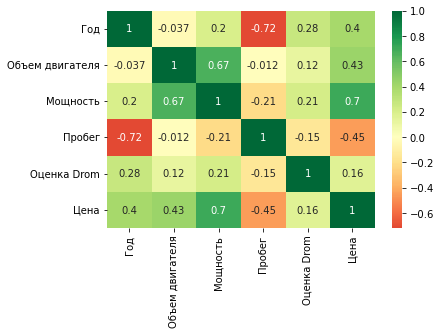

In [4]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

Отлично! Наиболее яркими зависимостями получились: Объем двигателя и мощность, год выпуска и пробег, мощность двигателя и цена. Первые две вполни легко объяснимы: чем больше у двигателя объем, тем большую мощность он способен выдать и чем раньше был выпущен автомобиль - тем дольше и дальше он катается по дорогам. Посмотрим на них на наличие всяких интересностей. 

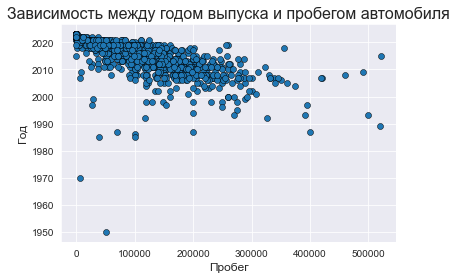

In [5]:
sns.set_style('darkgrid')
plt.title('Зависимость между годом выпуска и пробегом автомобиля',size=16)
plt.xlabel('Пробег',size=12)
plt.ylabel('Год',size=12)
sns.scatterplot(x='Пробег', y='Год', data=df, edgecolor='black', palette='cubehelix')
plt.show() 

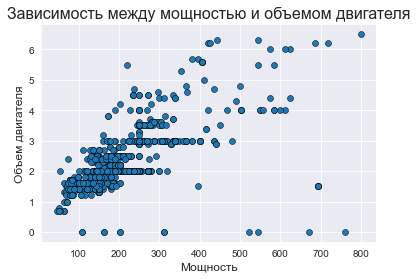

In [6]:
plt.title('Зависимость между мощностью и объемом двигателя',size=16)
plt.xlabel('Мощность',size=12)
plt.ylabel('Объем двигателя',size=12)
sns.scatterplot(x='Мощность', y='Объем двигателя', data=df, edgecolor='black', palette='cubehelix')
plt.show()

Можно заметить, что подавляющее большинство составляют новые автомобили с относительно небольшим пробегом, а так же автомобили с относительно невысокой мощностью. Вероятно, это особновано тем, что подавляющее большинство используемых автомобилей - легковые, которые владелец собирается менять на аналогичные, но более новые марки. 

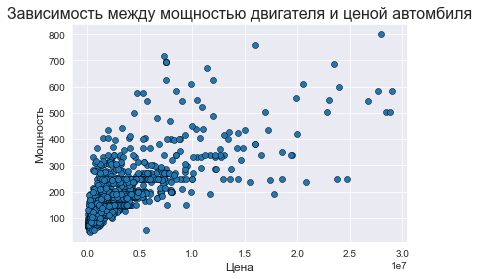

In [7]:
plt.title('Зависимость между мощностью двигателя и ценой автомбиля',size=16)
plt.xlabel('Цена',size=12)
plt.ylabel('Мощность',size=12)
sns.scatterplot(x='Цена', y='Мощность', data=df, edgecolor='black', palette='cubehelix')
plt.show()

Схожее распределение, показывающее что большинство автомобилей - относительно слабые и дешевые. 

Помимо подавляющего большинства на графиках выше также хорошо заметны единичные случаи сильных, дорогих или старых автомобилей. 

Хорошо, с численными переменными все стало немного понятнее. Но что со всем остальным? Давайте посмотрим, что встречается чаще всего

In [8]:
df.describe(include='object')

,Название,Топливо,Коробка передач,Привод,Цвет,Руль
count,1370,1370,1370,1370,1370,1370
unique,404,3,4,3,15,2
top,Kia Rio,бензин,автомат,передний,белый,левый
freq,30,1087,833,653,463,1321


Если с большей частью столбцов все было понятно еще на этапе обработки данных, то вот узнать, сколько различных марок машин сейчас продается и какая из них самая популярная достаточно интересно.

Но что если рассматривать по производителям и конкретным моделям?

In [53]:
data2 = pd.DataFrame()
data2[['Производитель', 'Модель']] = df['Название'].str.split(' ', 1, expand=True)
data2

,Производитель,Модель
0,Kia,Mohave
1,Hyundai,Santa Fe
2,Toyota,RAV4
3,Jeep,Gladiator
4,Jeep,Wrangler
...,...,...
1365,Volvo,XC60
1366,Audi,A8
1367,BMW,3-Series
1368,Geely,Tugella FY11


Как видно, даже отделив Kia от Rio, они все равно остаются самыми популярными среди производителей и моделей соответственно 

In [60]:
data2.describe()

,Производитель,Модель
count,1370,1370
unique,66,404
top,Kia,Rio
freq,148,30
